# Old

In [1]:
from model.afnonet import AFNONet

In [2]:
from utils.tools import getModelSize

In [7]:
model = AFNONet((32,64),2,70,70,768,history_length=6,unique_up_sample_channel=70)

In [4]:
model.unique_up_sample_channel

70

In [5]:
from mltool.universal_model_util import get_model_para_detail

In [8]:
param_sum, buffer_sum, all_size = getModelSize(model)
print(f" Number of Parameters: {param_sum}, Number of Buffers: {buffer_sum}, Size of Model: {all_size:.4f} MB\n")

 Number of Parameters: 72391391, Number of Buffers: 0, Size of Model: 276.1512 MB



In [1]:
from model.patch_model import NaiveConvModel2D

In [4]:
import torch

In [2]:
model = NaiveConvModel2D((32,64))

In [5]:
a = torch.randn(1,20,32,64)

In [9]:
from utils.tools import get_center_around_indexes

In [10]:
img_shape=(32,64)
patch_range=5
center_index,around_index=get_center_around_indexes(patch_range,img_shape)

In [13]:
around_index.shape

(28, 64, 2, 5, 5)

In [29]:
patch_range=5
delta = [list(range(-(patch_range//2),patch_range//2+1))]*2
delta = np.meshgrid(*delta)

In [30]:
delta[0].shape

(5, 5)

In [75]:
delta = [list(range(-(patch_range//2),patch_range//2+1))]*len(center)
delta = np.meshgrid(*delta)
pos  = [c+dc for c,dc in zip(center,delta)]
pos[-1]= pos[-1]%64

px = x + dx
py = y + dy
np.stack([px.flatten(),py.flatten()])

array([[2, 3, 4, 2, 3, 4, 2, 3, 4],
       [2, 2, 2, 3, 3, 3, 4, 4, 4]])

In [77]:
import torch

In [78]:
coordinate = np.arange(36).reshape(1,1,6,6)
print(coordinate)

[[[[ 0  1  2  3  4  5]
   [ 6  7  8  9 10 11]
   [12 13 14 15 16 17]
   [18 19 20 21 22 23]
   [24 25 26 27 28 29]
   [30 31 32 33 34 35]]]]


In [79]:
coordinate[:,:,pos].shape

(1, 1, 2, 3, 3, 6)

In [80]:
print(coordinate[:,:,x,y][0,0])
print(coordinate[:,:,pos[0],pos[1]][0,0])

21
[[14 20 26]
 [15 21 27]
 [16 22 28]]


In [19]:
from model.FEDformer import *

In [ ]:
nn.BatchNorm3d()

In [37]:
class moving_avg_spacetime(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super().__init__()
        assert len(kernel_size)==3
        self.kernel_size = np.array(kernel_size)
        self.avg         = nn.AvgPool3d(kernel_size=kernel_size, stride=stride, padding=0)
        self.pad_front   = self.kernel_size - 1-np.floor((self.kernel_size - 1) // 2)
        self.pad_end     = np.floor((self.kernel_size - 1) // 2)
        self.pad         = np.stack([self.pad_front,self.pad_end],1)[::-1].flatten().astype('int').tolist()
        print(self.pad)
    def forward(self, x):
        # padding on the both ends of time series
        # the input must be (B,*Space,T,C)， the -1 dim is embed channel, the -2 dim is time channel
        shape = x.shape
        BSpace_shape = shape[:-2]
        C = shape[-1]
        permute_order = [0,-1] + list(range(1,len(shape)-1))
        x = x.permute(*permute_order)#-->(B, *Space,T, C)-->(B, C, *Space,T)
        x = self.avg(F.pad(x,self.pad, mode='replicate'))
        permute_order = [0] + list(range(2,len(shape))) + [1]
        x = x.permute(*permute_order)
        return x

In [38]:
layer = moving_avg_spacetime((5,3,2),1)

[1, 0, 1, 1, 2, 2]


In [39]:
a=torch.randn(1,32,64,6,7)
layer(a).shape

torch.Size([1, 32, 64, 6, 7])

In [1]:
from model.physics_model import *

In [5]:
from model.afnonet import *

In [2]:
from utils.params import *

In [4]:
args=get_args(args=[])

In [10]:
backbone = AFNONet((32,64),2,265,20,depth=1)

In [11]:
layer = DirectSpace_Feature_Model(args,backbone)

h intervel: 32 , w intervel: 64
please notice we will using dt= 3600*1 as intertime


In [12]:
a= torch.randn(1,4,5,32,64)

In [14]:
torch.std_mean(layer(a))

(tensor(0.5915, grad_fn=<StdMeanBackward0>),
 tensor(-0.0057, grad_fn=<StdMeanBackward0>))

In [103]:
layer = Second_Derivative_Layer()

a=torch.randn(1,1,32,64)

layer(a).shape

torch.Size([1, 1, 32, 64])

In [73]:
B=2
P=4
a=torch.randn(B,P,3,32,64).cuda()
layer=  First_Derivative_Layer(dim=3).cuda()
runtime_weight=layer.runtime_weight

In [74]:
%%timeit
x = torch.conv3d(a.flatten(0,1).unsqueeze(1),runtime_weight).reshape(*a.shape[:-1],-1)

34.8 µs ± 130 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [76]:
%%timeit
x2 = torch.conv1d(a.flatten(0,-2).unsqueeze(1),runtime_weight[0,0]).reshape(*a.shape[:-1],-1)

43.1 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [20]:
torch.dist(x,x2)

tensor(0.)

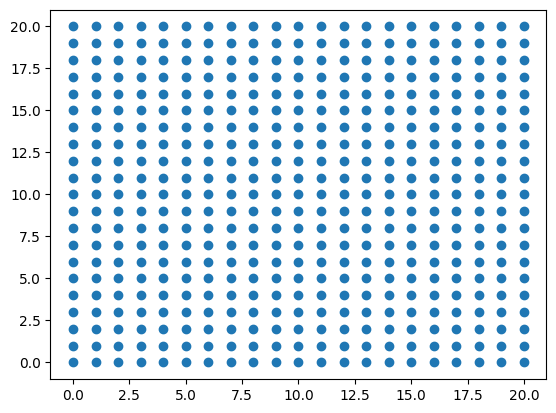

In [14]:
%matplotlib inline
plt.scatter(x,y)
#plt.scatter([10],[10],'r')

In [ ]:
def get_fourier_drive(x, position,pad):

    if len(position)==1:position = position[0]
    base_len          = np.array(x.shape[position])
    interpolate_shape = base_len + (base_len-1)*pad
    interpolate_shape = tuple(interpolate_shape)
    if isinstance(position,int) or len(position) == 1
        x = x.transpose(-1,position)
        out_shape = x.shape[:-1]
        x = x.reshape(x.size(0),-1,x.size(-1))
        b = torch.nn.functional.interpolate(x,interpolate_shape,mode='linear',align_corners=True)
        bf = torch.fft.rfft(b,dim=-1)
        kbf= bf*torch.fft.rfftfreq(b.size(-1)).reshape(1,1,-1)
        kb = torch.fft.irfft(kbf,dim=-1)
        index = torch.arange(0,b.size(-1)+1,base_len-1)
        kb = kb[...,index]

In [33]:
#from tkinter.messagebox import NO
import numpy as np
import torch,os,io,socket
from torchvision import datasets, transforms
hostname = socket.gethostname()
from functools import lru_cache
import traceback
from tqdm import tqdm
import pandas as pd
from utils.timefeatures import time_features
import os
import h5py


In [34]:
datatimelist  = np.arange(np.datetime64("1979-01-01"), np.datetime64("2016-01-01"), np.timedelta64(6, "h"))
timestamp = time_features(pd.to_datetime(datatimelist)).transpose(1, 0)


In [43]:
pd.to_datetime(np.datetime64("1980-12-31")).dayofyear

366

In [41]:
pd.to_datetime(datatimelist)[0].dayofyear

1

In [38]:
timestamp[:10,[0,-1]]

array([[-0.5       , -0.5       ],
       [-0.23913043, -0.5       ],
       [ 0.02173913, -0.5       ],
       [ 0.2826087 , -0.5       ],
       [-0.5       , -0.49726027],
       [-0.23913043, -0.49726027],
       [ 0.02173913, -0.49726027],
       [ 0.2826087 , -0.49726027],
       [-0.5       , -0.49452055],
       [-0.23913043, -0.49452055]])

In [1]:
from JCmodels.fourcastnet import *

In [2]:
model = AFNONet((32,64))

In [5]:
a = torch.randn(1,4,5,32,64)

In [6]:
model(a).shape

torch.Size([1, 4, 5, 32, 64])

#### FEDformer

#### complex version AdaptiveFourierNeuralOperator

##### validate

In [64]:
def multiply(input, weights):
    return torch.einsum('...bd,bdk->...bk', input, weights)

In [114]:
B=1
h=32;w=64;C=2
num_blocks=1
block_size=2

w1 = torch.randn(num_blocks, block_size, block_size, dtype=torch.cfloat)
b1 = torch.randn(num_blocks, block_size, dtype=torch.cfloat)
w2 = torch.randn(num_blocks, block_size, block_size, dtype=torch.cfloat)
b2 = torch.randn(num_blocks, block_size, dtype=torch.cfloat)

In [126]:
def original_realize(x,w1,b1,w2,b2):
    x = torch.fft.rfft2(x, dim=(1, 2), norm='ortho');
    x = x.reshape(B, x.shape[1], x.shape[2], num_blocks, block_size)
    x_real = F.relu(multiply(x.real, w1.real) - multiply(x.imag, w1.imag) + b1.real, inplace=True)
    x_imag = F.relu(multiply(x.real, w1.imag) + multiply(x.imag, w1.real) + b1.imag, inplace=True)
    x = torch.stack([x_real, x_imag], dim=-1)
    x = torch.view_as_complex(x)
    return x

def complex_version_realize(x,w1,b1,w2,b2):
    x = torch.fft.rfft2(x, dim=(1, 2), norm='ortho');
    x = x.reshape(B, x.shape[1], x.shape[2], num_blocks, block_size)
    x = multiply(x,w1)+b1
    x = nonlinear_activate(x)
    return x
x  = torch.randn(B, h, w, C)
y1 = original_realize(x,w1,b1,w2,b2)
y2 = complex_version_realize(x,w1,b1,w2,b2)
torch.dist(y1,y2)

tensor(0.)

In [34]:
from model.afnonet import *

##### AFNONet3D

In [212]:
class PartReLU_Complex(nn.Module):
    def forward(self,x):
        F.relu(x.real, inplace=True)
        F.relu(x.imag, inplace=True)
        return x

class AdaptiveFourierNeuralOperator(nn.Module):
    def __init__(self, dim, img_size, fno_blocks=4,fno_bias=True, fno_softshrink=False,nonlinear_activate=PartReLU_Complex()):
        super().__init__()

        self.hidden_size = dim
        self.img_size   = img_size
        self.num_blocks = fno_blocks
        self.block_size = self.hidden_size // self.num_blocks
        assert self.hidden_size % self.num_blocks == 0

        self.scale = 0.02
        self.w1 = torch.nn.Parameter(self.scale * torch.randn(self.num_blocks, self.block_size, 
                                                              self.block_size, dtype=torch.cfloat))
        self.b1 = torch.nn.Parameter(self.scale * torch.randn(self.num_blocks, self.block_size, 
                                                              dtype=torch.cfloat))
        self.w2 = torch.nn.Parameter(self.scale * torch.randn(self.num_blocks, self.block_size, 
                                                              self.block_size, dtype=torch.cfloat))
        self.b2 = torch.nn.Parameter(self.scale * torch.randn(self.num_blocks, self.block_size, 
                                                              dtype=torch.cfloat))
        self.relu = nonlinear_activate

        if fno_bias:
            self.bias = nn.Conv1d(self.hidden_size, self.hidden_size, 1)
        else:
            self.bias = None

        self.softshrink = fno_softshrink

    def multiply(self, input, weights):
        return torch.einsum('...bd,bdk->...bk', input, weights)

    def forward(self, x):
        B, N, C = x.shape    
        bias = self.bias(x.permute(0, 2, 1)).permute(0, 2, 1) if self.bias else 0
        #timer.restart(2)
        x = x.reshape(B, *self.img_size, C)
        fft_dim = tuple(range(1,len(self.img_size)+1))
        print(fft_dim)
        #timer.record('reshape1','filter',2)
        print(x.shape)
        x = torch.fft.rfftn(x, dim=fft_dim, norm='ortho');
        #timer.record('rfft2','filter',2)
        print(x.shape)
        x = x.reshape(*x.shape[:-1], self.num_blocks, self.block_size)
        #timer.record('reshape2','filter',2)
        x = self.multiply(x,self.w1)+self.b1
        x = self.relu(x)
        x = self.multiply(x,self.w2)+self.b2
        x = F.softshrink(x, lambd=self.softshrink) if self.softshrink else x
        #with torch.cuda.amp.autocast(enabled=False):
        #x = x.float()   
        #x = torch.view_as_complex(x)
        #timer.record('reset','filter',2)
        x = x.flatten(-2,-1)
        #timer.record('reshape3','filter',2)
        print(x.shape)
        x = torch.fft.irfftn(x, s=self.img_size,dim=fft_dim, norm='ortho')
        print(x.shape)
        #x = x.half()
        #timer.record('irfft2','filter',2)
        x = x.reshape(B, N, C)
        #timer.record('reshape4','filter',2)
        return x + bias

class Block(nn.Module):
    def __init__(self, dim, mlp_ratio=4., drop=0., drop_path=0., act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm, region_shape=(14,8), fno_blocks=3,double_skip=False, fno_bias=False, fno_softshrink=False):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.filter = AdaptiveFourierNeuralOperator(dim, region_shape,fno_blocks=fno_blocks,fno_bias=fno_bias,fno_softshrink=fno_softshrink)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.double_skip = double_skip

    def forward(self, x):
        residual = x
        #timer.restart(1)
        x = self.norm1(x)
        #timer.record('norm1','forward_features',1)
        x = self.filter(x)
        #timer.record('filter','forward_features',1)
        if self.double_skip:
            x += residual
            residual = x;
        #timer.record('residual','forward_features',1)
        x = self.norm2(x)
        #timer.record('norm2','forward_features',1)
        x = self.mlp(x)
        #timer.record('mlp','forward_features',1)
        x = self.drop_path(x)
        #timer.record('drop_path','forward_features',1)
        x += residual
        #timer.record('residual','forward_features',1)
        return x

class PatchEmbed(nn.Module):
    def __init__(self, img_size=None, patch_size=8, in_chans=13, embed_dim=768):
        super().__init__()

        if img_size is None:raise KeyError('img is None')
        patch_size   = [patch_size]*len(img_size) if isinstance(patch_size,int) else patch_size
        
        num_patches=1
        out_size=[]
        for i_size,p_size in zip(img_size,patch_size):
            if p_size%i_size:
                num_patches*=i_size// p_size
                out_size.append(i_size// p_size)
            else:
                raise NotImplementedError(f"the patch size ({patch_size}) cannot divide the img size {img_size}")
        self.img_size    = tuple(img_size)
        self.patch_size  = tuple(patch_size)
        self.num_patches = num_patches
        self.out_size    = tuple(out_size)
        conv_engine = [nn.Conv1d,nn.Conv2d,nn.Conv3d]
        self.proj   = conv_engine[len(img_size)-1](in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, = x.shape[:2]
        inp_size = x.shape[2:]
        assert tuple(inp_size) == self.img_size, f"Input image size ({inp_size}) doesn't match model set size ({self.img_size})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class AFNONet(nn.Module):
    """
    
    """
    def __init__(self, img_size, patch_size=8, in_chans=20, out_chans=20, embed_dim=768, depth=12, mlp_ratio=4.,
                 uniform_drop=False, drop_rate=0., drop_path_rate=0., norm_layer=None,
                 dropcls=0, checkpoint_activations=False, fno_blocks=3,double_skip=False,
                 fno_bias=False, fno_softshrink=False,debug_mode=False):
        super().__init__()

        assert img_size is not None
        self.checkpoint_activations=checkpoint_activations
        self.embed_dim = embed_dim
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        self.img_size = img_size
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches      = self.patch_embed.num_patches
        patch_size       = self.patch_embed.patch_size
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        self.final_shape = self.patch_embed.out_size

        if uniform_drop:
            dpr = [drop_path_rate for _ in range(depth)]  # stochastic depth decay rule
        else:
            dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule

        self.blocks = nn.ModuleList([Block(dim=embed_dim, mlp_ratio=mlp_ratio, drop=drop_rate,
                                           drop_path=dpr[i], 
                                           norm_layer=norm_layer,
                                           region_shape=self.final_shape,
                                           double_skip=double_skip,
                                           fno_blocks=fno_blocks,
                                           fno_bias=fno_bias,
                                           fno_softshrink=fno_softshrink) for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        # self.num_features = out_chans * img_size[0] * img_size[1]
        # self.representation_size = self.num_features * 8
        # self.pre_logits = nn.Sequential(OrderedDict([
        #     ('fc', nn.Linear(embed_dim, self.representation_size)),
        #     ('act', nn.Tanh())
        # ]))
        conf_list = [{'kernel_size':[],'stride':[],'padding':[]},
                     {'kernel_size':[],'stride':[],'padding':[]},
                     {'kernel_size':[],'stride':[],'padding':[]}]
        conv_set = {8:[[2,2,0],[2,2,0],[2,2,0]],
                    4:[[2,2,0],[3,1,1],[2,2,0]],
                    2:[[3,1,1],[3,1,1],[2,2,0]],
                    1:[[3,1,1],[3,1,1],[3,1,1]],
                   }
        for patch in patch_size:
            for slot in range(len(conf_list)):
                conf_list[slot]['kernel_size'].append(conv_set[patch][slot][0])
                conf_list[slot]['stride'].append(conv_set[patch][slot][1])
                conf_list[slot]['padding'].append(conv_set[patch][slot][2])

        transposeconv_engine = [nn.ConvTranspose1d,nn.ConvTranspose2d,nn.ConvTranspose3d][len(img_size)-1]
        self.pre_logits = nn.Sequential(OrderedDict([
            ('conv1', transposeconv_engine(embed_dim, out_chans*16, **conf_list[0])),
            ('act1', nn.Tanh()),
            ('conv2', transposeconv_engine(out_chans*16, out_chans*4, **conf_list[1])),
            ('act2', nn.Tanh())
        ]))

        # Generator head
        # self.head = nn.Linear(self.representation_size, self.num_features)
        self.head = transposeconv_engine(out_chans*4, out_chans, **conf_list[2])

        if dropcls > 0:
            print('dropout %.2f before classifier' % dropcls)
            self.final_dropout = nn.Dropout(p=dropcls)
        else:
            self.final_dropout = nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        self.apply(self._init_weights)
        self.debug_mode=debug_mode
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        x += self.pos_embed
        x = self.pos_drop(x)

        if not self.checkpoint_activations:
            for blk in self.blocks:
                x = blk(x)
        else:
            x = checkpoint_sequential(self.blocks, 4, x)

        x = self.norm(x).transpose(1, 2);print(x.shape)
        x = torch.reshape(x, [-1, self.embed_dim, *self.final_shape])
        return x

    def forward(self, x):
        ### we assume always feed the tensor (B, p*z, h, w)
        B, P ,h, w = x.shape
        x = x.reshape(B,-1,*self.img_size)
        #timer.restart(level=0)
        x = self.forward_features(x)
        #timer.record('forward_features',level=0)
        x = self.final_dropout(x)
        #timer.record('final_dropout',level=0)
        x = self.pre_logits(x)
        #timer.record('pre_logits',level=0)
        x = self.head(x)
        #timer.record('head',level=0)
        x = x.reshape(B,P,h,w)
        #timer.show_stat()
        #print("============================")

        return x

In [219]:
model = AFNONet(img_size=[10,32,64],patch_size=(1,8,8),depth=1)

In [220]:
a = torch.randn(1,20,10,32,64)

In [223]:
a = torch.randn(1,3,4,32,64).flatten(1,2)
torch.dist(a.reshape(1,-1,4,32,64).reshape(1,12,32,64),a)

tensor(0.)

In [225]:
a = torch.randn(1,12,32,64)
torch.dist(a.reshape(1,3,4,32,64).reshape(1,-1,32,64),a)

tensor(0.)

##### EulerEquationModel2

In [27]:
class EulerEquationModel2(nn.Module):
    def __init__(self, args, backbone):
        super().__init__()
        self.Dx= First_Derivative_Layer(position=-1, dim=3, mode=2)
        self.Dy= First_Derivative_Layer(position=-2, dim=3, mode=2)
        self.Dz= First_Derivative_Layer(position=-3, dim=3, mode=1)
        self.thermal_factor  = nn.Parameter(torch.randn(3).reshape(1,3,1,1))
        self.alpha = nn.Parameter(torch.randn(1))
        #self.p_list         = nn.Parameter(torch.Tensor([10,8.5,5]).reshape(1,3,1,1),requires_grad=False)
        self.backbone =  backbone
        self.monitor = True
    def forward(self, Field):
        # u^{t+1} &= u^{t} + F_x - \nabla (Vu)  + u \nabla\cdot V - \partial_x\phi\\
        # v^{t+1} &= v^{t} + F_y - \nabla (Vv)  + v \nabla\cdot V - \partial_y\phi\\
        # T^{t+1} &= T^{t} + Q/C_v + \frac{RT}{C_pp}\omega  - \nabla (VT) +T \nabla\cdot V\\
        # \phi^{t+1}&=\phi^{t} + wg  - \nabla (V\phi)+ \phi \nabla\cdot V \\
        # 0&\approx \nabla\cdot V
        # input -> Field  = [u ,v, T, p] --> (Batch, 4, z, y ,x)
        # need generate unknown data [Fx, Fy , Q, W, o]
        b, si_z, i_y, i_x = Field.shape
        s=4
        i_z= si_z//4
        MachineLearningPart = self.backbone(Field).reshape(b, s+1, i_z, i_y, i_x) #(Batch, 5, z, y ,x)
        ExternalForce = MachineLearningPart[:,:4] #(Batch, 4, z, y ,x)
        o = MachineLearningPart[:,4:5] #(Batch, 1, z, y ,x)
        Field = Field.reshape(b, s, i_z, i_y,  i_x) #(Batch, 5, z, y ,x)
        u = Field[:,0:1]#(Batch, 1, z, y ,x)
        v = Field[:,1:2]#(Batch, 1, z, y ,x)
        T = Field[:,2:3]#(Batch, 1, z, y ,x)
        p = Field[:,3:4]#(Batch, 1, z, y ,x)
        V = torch.cat([u,v,o],1)#(Batch, 3, z, y ,x)
        Nabla_cdot_V = (self.Dx(u[:,0]) + self.Dy(v[:,0]) + self.Dz(o[:,0])).unsqueeze(1)#(Batch, 1, z, y ,x)
        Nabla_V_Field= Nabla_cdot_V*Field #(Batch, 4, z, y ,x)
        Vphysics     = torch.stack([V*u,V*v,V*T,V*p],1)#(Batch,4, 3, z, y ,x)
        Vphysics_dx = self.Dx(Vphysics[:,:,0].flatten(0,1)).reshape(Field.shape)#(Batch, 4, z, y ,x)
        Vphysics_dy = self.Dy(Vphysics[:,:,1].flatten(0,1)).reshape(Field.shape)#(Batch, 4, z, y ,x)
        Vphysics_dz = self.Dz(Vphysics[:,:,2].flatten(0,1)).reshape(Field.shape)#(Batch, 4, z, y ,x)
        PhysicsPart = -Vphysics_dx - Vphysics_dy - Vphysics_dz + Nabla_V_Field #(Batch,4,z, y ,x)
        InteractionPart= torch.stack([self.Dx(p[:,0]),
                                      self.Dy(p[:,0]),
                                      self.thermal_factor*T[:,0]*o[:,0]],1)#(Batch,3,z, y ,x)
        InteractionPart= F.pad(InteractionPart,(0,0,0,0,0,0,0,1)) #(Batch,4,z, y ,x)
        Delta_Fd     = ExternalForce + self.alpha*(PhysicsPart + InteractionPart)
        Field        = Field+ Delta_Fd
        constrain    = Nabla_V_Field
        if not self.monitor:
            return Field.flatten(1,2),(constrain**2).mean()
        else:
            return Field.flatten(1,2),(constrain**2).mean(),{"ExternalForceFactor":(ExternalForce**2).mean().item(),
                                                             "PhysicsDrivenFactor":(PhysicsPart**2).mean().item(),
                                                             "InteractionPart":(InteractionPart**2).mean().item(),
                                                             "alpha":self.alpha.item()}
